# further :
- map by iplot for states
- background for plots (too light bars)
- delete month distribution
- dots onto worldmap


# questions and pseudocode solutions:
- how to download your mask to kaggle (look at the kernels in data science for good, there was one)
- can i return somehow country by its coordinates: https://stackoverflow.com/questions/20169467/how-to-convert-from-longitude-and-latitude-to-country-or-city
- sort boxplots by their quantity
- random sampling. just take 1000 samples from eash country or each shape. and than compare them.

- using geocoder take names, than create word cloud, or smth, as it says there are a lot of air bases


## conclusion draft :
- and finally : if one wants to catch alien, one should go the California or New Orlean and watch the sky on Saturday in July.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

In [6]:
ufo = pd.read_csv("scrubbed.csv")

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# cleaning

In [3]:
ufo.columns.values

array(['datetime', 'city', 'state', 'country', 'shape',
       'duration (seconds)', 'duration (hours/min)', 'comments',
       'date posted', 'latitude', 'longitude '], dtype=object)

### cleaning up the 'datetime' feature
- it has both '24:00' and '00:00' values but only 00:00 are relevant
- so we find them and replace with "00:00"
- then we convert `str` type to `TimeStamp`

In [4]:
row = -1
counter = 0
for i in ufo['datetime']:
    row += 1
    date, time_stamp = i.split()
    if time_stamp == '24:00':
        counter += 1
        ufo.iloc[row, 0] = " ".join([date, "00:00"])

In [7]:
# another variant :
ufo['datetime']=ufo['datetime'].replace({'24:00':'00:01'}, regex=True)

In [8]:
ufo['datetime'] = pd.to_datetime(ufo['datetime'])

### cleaning duration (seconds)

when trying to convert 'duration (seconds)' feature to `float`, we encounter `ValueError`

In [50]:
ufo['duration (seconds)'].astype(float)


ValueError: could not convert string to float: '0.5`'

**trying to find what causes the error : **

In [9]:
typos = []

row = -1 
for el in ufo['duration (seconds)']:
    row += 1
    if type(el) == float:
        continue
    for char in el:
        if char.isnumeric() or char == ".":
            continue
        else:
            typos.append((row, el))
            break
typos

[(27822, '2`'), (35692, '8`'), (41201, '2631600  '), (58591, '0.5`')]

**there're just a few typos, we'll just correct them manually : **


In [10]:
correct = {27822: '2', 35692: '8', 41201: '2631600', 58591: '0.5'  }

In [11]:
for k, v in correct.items():
    ufo.loc[k, 'duration (seconds)'] = v

**converting duration to ```float``` type : **

In [12]:
ufo['duration_sec'] = ufo['duration (seconds)'].astype(float)

## checking up empty values : 

In [13]:
ufo.isnull().sum()

datetime                   0
city                       0
state                   5797
country                 9670
shape                   1932
duration (seconds)         0
duration (hours/min)       0
comments                  15
date posted                0
latitude                   0
longitude                  0
duration_sec               0
dtype: int64

**replacing Nans with 'unknown' and 'no description' : **

In [14]:
# TOFIX : assign to the same column, delete 'inplace' parameter, somehow it doesn't work sometimes.

ufo['state'].fillna('unknown', inplace=True)
ufo['country'].fillna('unknown', inplace=True)
ufo['shape'].fillna('unknown', inplace=True)
ufo['comments'].fillna('no description', inplace=True)

** removing duration as we have that feature in seconds we can convert in any value : **

In [15]:
ufo.drop(['duration (hours/min)', 'duration (seconds)' ], axis=1, inplace=True)

** adding duration in minutes for more convenience : **

In [16]:
ufo['duration_min'] = ufo['duration_sec'] / 60

## clearing latitude and longitude : 

In [17]:
ufo['latitude'].astype(float)

ValueError: could not convert string to float: '33q.200088'

In [18]:
row = -1
container = []
for i in ufo['latitude']:
    row += 1
    try:
        float(i)
    except ValueError:
        container.append((i, row))

In [19]:
container

[('33q.200088', 43782)]

** finding index of the column : **

In [20]:
for c, v in enumerate(ufo.columns.values):
    print(c, '--->', v)

0 ---> datetime
1 ---> city
2 ---> state
3 ---> country
4 ---> shape
5 ---> comments
6 ---> date posted
7 ---> latitude
8 ---> longitude 
9 ---> duration_sec
10 ---> duration_min


In [21]:
ufo.iloc[43782 , 7] = '33.200088'

In [22]:
ufo['latitude'] = ufo['latitude'].astype(float)

** 'longitude' feature name has empty space at the end, which may cause embarassement and hate to programming. Let's fix it : **

In [23]:
ufo.columns.values

array(['datetime', 'city', 'state', 'country', 'shape', 'comments',
       'date posted', 'latitude', 'longitude ', 'duration_sec',
       'duration_min'], dtype=object)

In [24]:
ufo.columns.values[8] = 'longitude'

In [25]:
ufo['longitude'] = ufo['longitude '].astype(float)

# Exploratory analysis and visualization : 

## UFO witnesses over time


the data are taken from : https://www.history.com/news/ufo-sightings-credible-modern they say, it's credible. 

In [26]:
ufo['year'] = ufo['datetime'].dt.year.astype(int)
temp = ufo['year'].value_counts().sort_index()

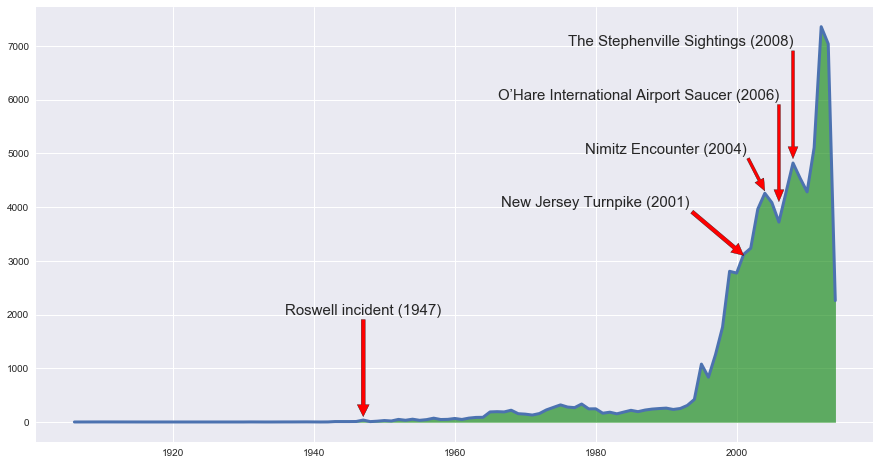

In [29]:
fig = plt.figure(figsize=(15, 8))
plt.plot(temp, lw=3)
plt.fill_between(temp.index, temp, color='green', alpha=0.6)

plt.annotate("Roswell incident (1947)", xy=(1947, 100), xytext=(1947, 2000), size=15,
             horizontalalignment='center',
             arrowprops=dict(facecolor="red"))

plt.annotate("New Jersey Turnpike (2001)", xy=(2001, 3100), xytext=(1980, 4000), size=15,
             horizontalalignment='center',
             arrowprops=dict(facecolor="red"))

plt.annotate("Nimitz Encounter (2004)", xy=(2004, 4300), xytext=(1990, 5000), size=15,
             horizontalalignment='center',
             arrowprops=dict(facecolor="red", width=3, headwidth=10))

plt.annotate("O’Hare International Airport Saucer (2006)", xy=(2006, 4100), xytext=(2006, 6000), size=15,
             horizontalalignment='right',
             arrowprops=dict(facecolor="red", width=3, headwidth=10))
plt.annotate("The Stephenville Sightings (2008)", xy=(2008, 4900), xytext=(2008, 7000), size=15,
             horizontalalignment='right',
             arrowprops=dict(facecolor="red", width=3, headwidth=10))


#plt.axvline(2001, lw=1, color="black") 
#plt.axvline(2004, lw=1, alpha=0.25, color="black") 

#plt.axvline(2006, lw=1, alpha=0.25, color="black") 

#plt.axvline(2008, lw=1, alpha=0.25, color="black") 

plt.show()

the idea of annotating movies is stolen from cool notebook of  :

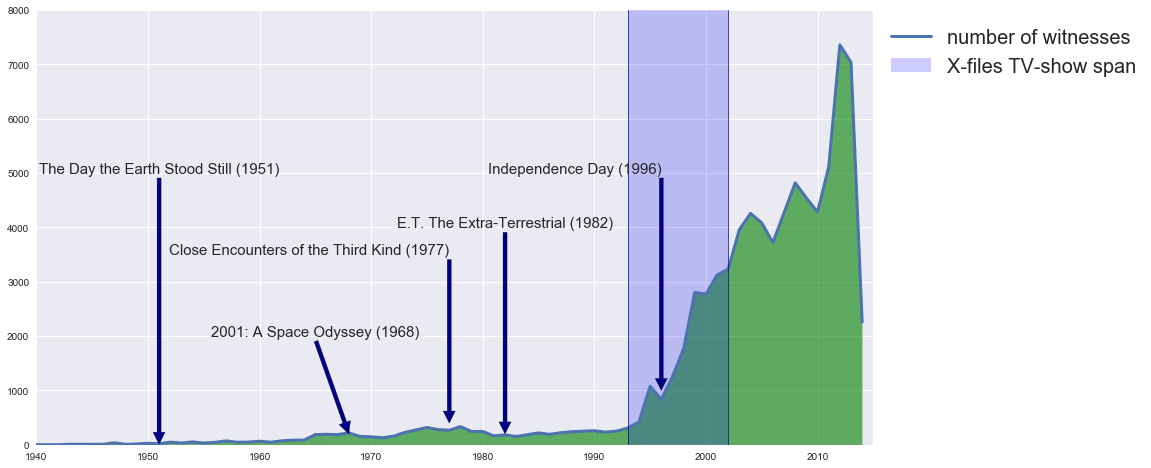

In [104]:
fig = plt.figure(figsize=(15, 8))
plt.plot(temp, lw=3, label="number of witnesses")
plt.fill_between(temp.index, temp, color='green', alpha=0.6)


plt.axvline(1993, lw=1, color="darkblue", alpha=0.7) 

plt.axvline(2002, lw=1, color="darkblue", alpha=0.7)

x = [1993, 1993, 2002, 2002]
y = [0, 8000, 8000, 0]

plt.fill(x, y, 'b', alpha=0.2, label='X-files TV-show span')

#plt.axvline(2001, lw=1, color="black") 
#plt.axvline(2004, lw=1, alpha=0.25, color="black") 

#plt.axvline(2006, lw=1, alpha=0.25, color="black") 

#plt.axvline(2008, lw=1, alpha=0.25, color="black") 
plt.annotate("""E.T. The Extra-Terrestrial (1982)""", xy=(1982, 200), xytext=(1982, 4000), size=15,
             horizontalalignment='center',
             arrowprops=dict(facecolor="darkblue"))

plt.annotate("Independence Day (1996)", xy=(1996, 1000), xytext=(1996, 5000), size=15,
             horizontalalignment='right',
             arrowprops=dict(facecolor="darkblue"))

plt.annotate("The Day the Earth Stood Still (1951)", xy=(1951, 10), xytext=(1951, 5000), size=15,
             horizontalalignment='center',
             arrowprops=dict(facecolor="darkblue"))

plt.annotate("Close Encounters of the Third Kind (1977)", xy=(1977, 400), xytext=(1977, 3500), size=15,
             horizontalalignment='right',
             arrowprops=dict(facecolor="darkblue"))



plt.annotate("2001: A Space Odyssey (1968)", xy=(1968, 200), xytext=(1965, 2000), size=15,
             horizontalalignment='center',
             arrowprops=dict(facecolor="darkblue"))
    
    
plt.legend(bbox_to_anchor=(1.0, 1.0), prop={'size': 20})

plt.ylim(0, 8000)
plt.xlim(1940, 2015)
plt.show()

In [28]:
ufo.columns.values

array(['datetime', 'city', 'state', 'country', 'shape', 'comments',
       'date posted', 'latitude', 'longitude', 'duration_sec',
       'duration_min', 'longitude', 'year'], dtype=object)

## UFO shapes

In [94]:
temp = ufo['shape'].value_counts().sort_values(ascending=False)

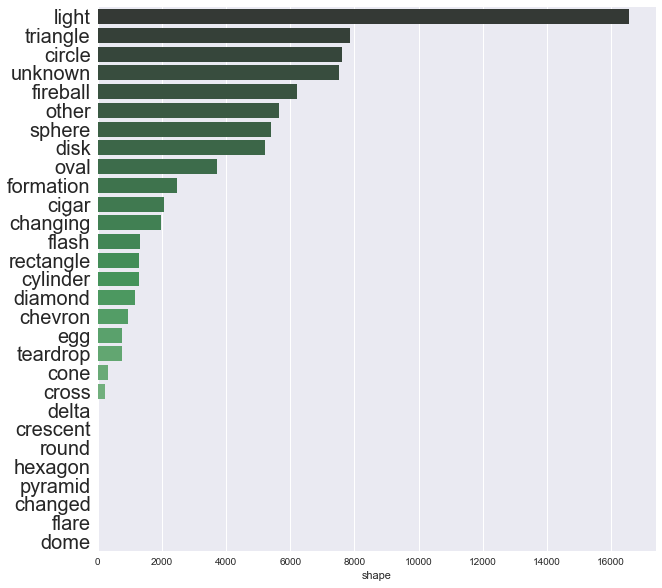

In [96]:
plt.figure(figsize=(10,10))
sns.barplot(temp, temp.index, palette="Greens_d")
plt.yticks(fontsize=20)
plt.show()

## shapes over years. Rise of Unknowns and Light Prevalence

In [97]:
shape_year = ufo[['shape', 'year']]

You can clearly observe the pike in the unknown shape. we call it: "The Rise of Unknowns". Further studies are needed to investigate this phenomena. As we've created this category ourselves, we lack data on this year, or, perhaps ufo's were so careful, so that people couldn't grasp their shape
The second investigation is the prevalence of the light. Which is an issue as well

In [98]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [99]:
data = []

for ufo_shape in temp.index[:]:
    df = pd.DataFrame(shape_year.loc[ufo['shape'] == ufo_shape, 'year'])
    shape = df['year'].value_counts()
    shape.sort_index(ascending=True, inplace=True)
    trace = go.Scatter(x=shape.index, y=shape, mode="lines", name=ufo_shape)
    data.append(trace)
    
iplot(data)



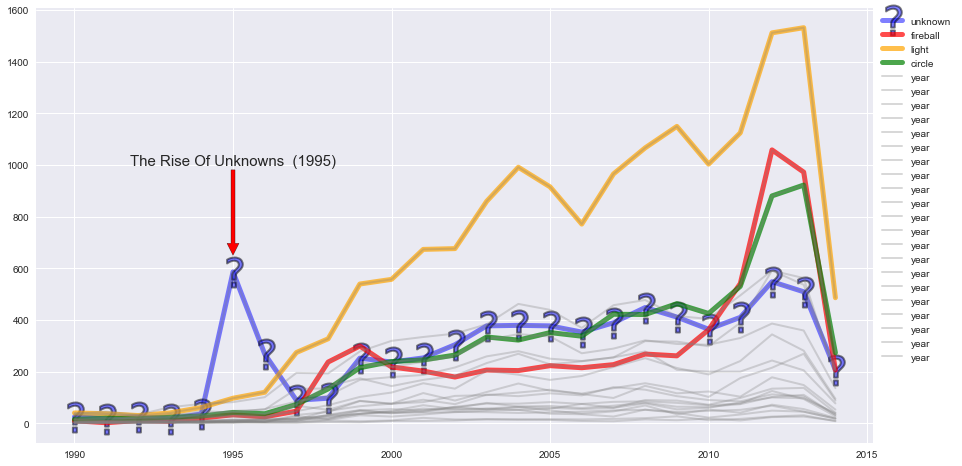

In [108]:
plt.figure(figsize=(15, 8))

unk = pd.DataFrame(shape_year.loc[ufo['shape'] == 'unknown', 'year'])
unk = unk['year'].value_counts()
unk.sort_index(ascending=True, inplace=True)   
plt.plot(unk.loc[1990:], label='unknown', lw=5, alpha=0.5, c='blue', marker='$?$', ms="30", markeredgewidth=2, 
        markeredgecolor='black')

fire = pd.DataFrame(shape_year.loc[ufo['shape'] == 'fireball', 'year'])
fire = fire['year'].value_counts()
fire.sort_index(ascending=True, inplace=True)   
plt.plot(fire.loc[1990:], label='fireball', lw=5, alpha=0.7, c='red')

light = pd.DataFrame(shape_year.loc[ufo['shape'] == 'light', 'year'])
light = light['year'].value_counts()
light.sort_index(ascending=True, inplace=True)   
plt.plot(light.loc[1990:], label='light', lw=5, alpha=0.7, c='orange')

circle = pd.DataFrame(shape_year.loc[ufo['shape'] == 'circle', 'year'])
circle = circle['year'].value_counts()
circle.sort_index(ascending=True, inplace=True)   
plt.plot(circle.loc[1990:], label='circle', lw=5, alpha=0.7, c='green')

for ufo_shape in temp.index[:21]:
    df = pd.DataFrame(shape_year.loc[ufo['shape'] == ufo_shape, 'year'])
    shape = df['year'].value_counts()
    shape.sort_index(ascending=True, inplace=True)
    plt.plot(shape.loc[1990:], lw=2, c='grey', alpha=0.3)

plt.annotate("The Rise Of Unknowns  (1995)", xy=(1995, 650), xytext=(1995, 1000), size=15,
             horizontalalignment='center',
             arrowprops=dict(facecolor="red"))

plt.legend(bbox_to_anchor=(1.0, 1.0))



## UFO per country

In [110]:
temp = ufo['country'].value_counts()
temp.sort_values(inplace=True, ascending=False)

In [111]:
x_label = temp.index.values
y_data = temp.tolist()

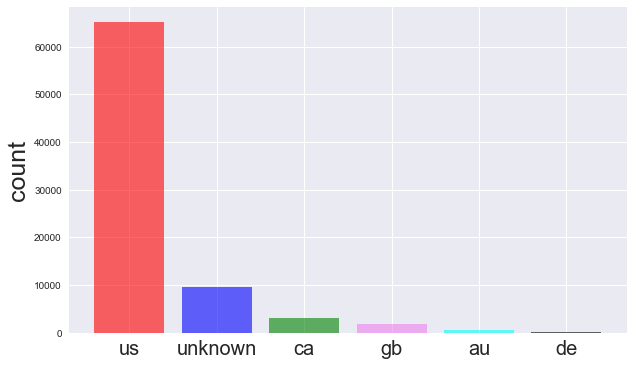

In [112]:
fig = plt.figure(figsize=(10, 6))
plt.bar(range(len(x_label)),  y_data, color=['red', 'blue', 'green', 'violet', 'cyan', 'black'], alpha=0.6)
plt.xticks(list(range(len(x_label))), x_label, fontsize=20)
plt.ylabel('count', fontsize=25)

plt.show()

## UFO visit cities mostly in the USA

In [113]:
temp = ufo['city'].value_counts()
temp.sort_values(inplace=True, ascending=False)

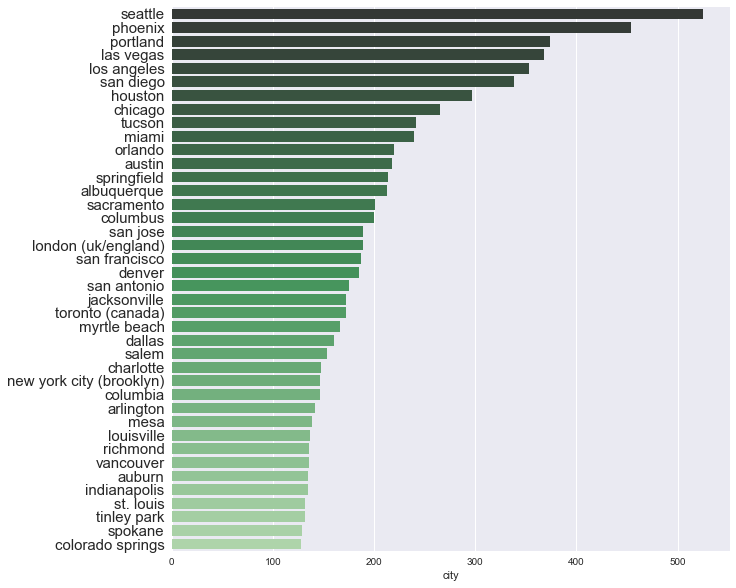

In [117]:
plt.figure(figsize=(10,10))
sns.barplot(temp[:40], temp.index[:40], palette="Greens_d")
plt.yticks(fontsize=15)
plt.show()

## UFO prefers California most of all

In [37]:
f = open('us_states_codes.txt')

In [38]:
d = {}
for line in f:
    d[line.split()[2].lower()] = line.split()[0]

ufo['state'] = ufo['state'].map(d)

In [122]:
temp = ufo['state'].value_counts()
temp.sort_values(inplace=True, ascending=False)
x_label = temp.index.values
y_data = temp.tolist()

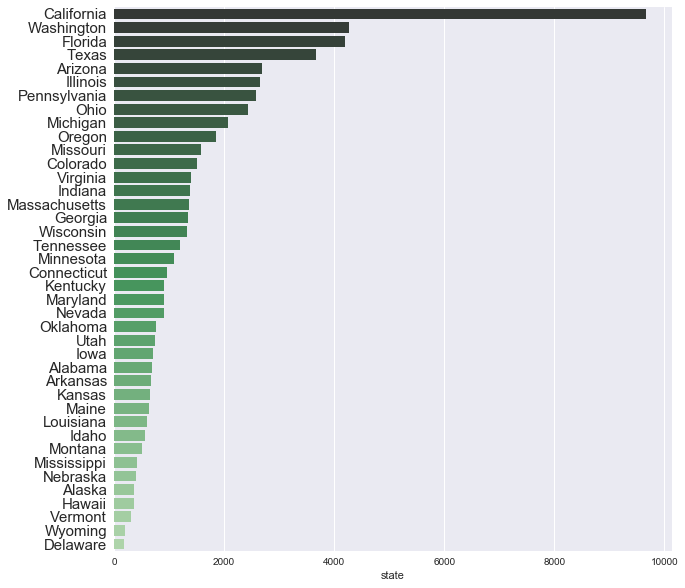

In [123]:
plt.figure(figsize=(10,10))
sns.barplot(temp, temp.index, palette="Greens_d")
plt.yticks(fontsize=15)
plt.show()

# TODO: create here chloroplete saturaion map by iplot plotly

- intersting stuff to do:
1. are there correlation with population and num of witnesses of UFO?

## Duration 

- this feature is rather skewed : we have many witnesses which observed ufo for about more than 24 hours
- dropping these outliers, we get rather nice distribution
- most people say round values of observing UFOs. Look at that 5, 10, 15, 20, 25, 30 etc values

**conclusion draft : **
- UFOs give a chance to be observed for about 1 minute.

C:\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


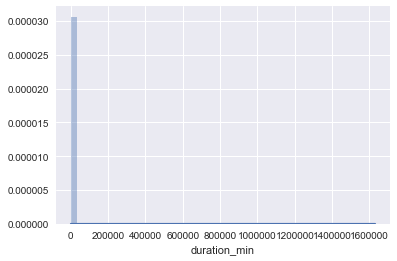

In [66]:
sns.distplot(ufo['duration_min'])
plt.show()

In [69]:
ufo['duration_min'].mean()

150.28148360574346

In [70]:
ufo['duration_min'].std()

10336.946504858231

In [71]:
ufo['duration_min'].min()

1.6666666666666667e-05

In [72]:
ufo['duration_min'].max() / 60

27176.666666666668

In [73]:
temp = ufo['duration_min']

In [74]:
temp = temp.sort_values()

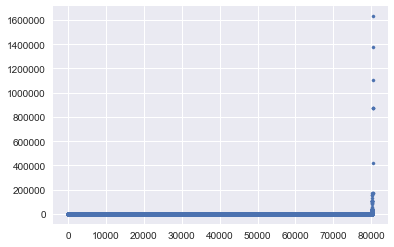

In [75]:
plt.scatter(range(1, len(temp) + 1), temp.values, s=10)
plt.show()

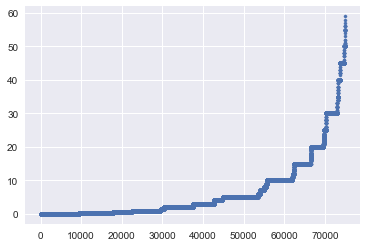

In [68]:
plt.scatter(range(1, len(temp) + 1), temp.values, s=10)
plt.show()

In [19]:
q = ufo["duration_min"].quantile(0.95)

In [62]:
temp = temp[temp < q]

C:\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


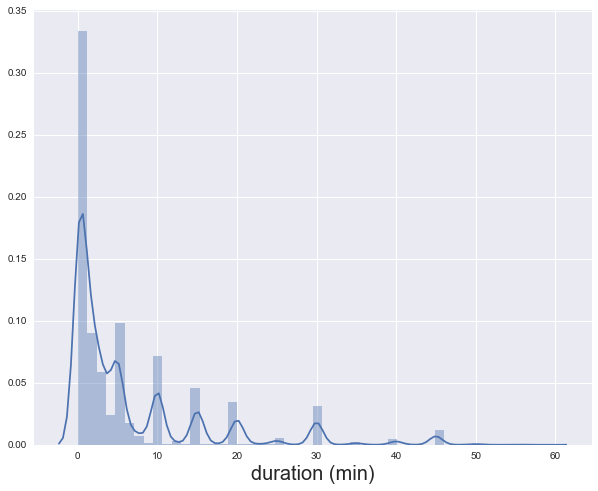

In [74]:
plt.figure(figsize=(10, 8))
sns.distplot(temp)
plt.xlabel('duration (min)', fontsize=20)
plt.show()

In [76]:
ufo.columns

Index(['datetime', 'city', 'state', 'country', 'shape', 'comments',
       'date posted', 'latitude', 'longitude', 'duration_sec', 'duration_min',
       'longitude'],
      dtype='object')

# Comments analysis

In [124]:
text = ' '.join(ufo['comments'])

In [125]:
import re

In [126]:
text = re.sub('[!@#&44]', '', text)
text = text.replace('Note', '')
text = text.replace('quot', '')

In [127]:
from wordcloud import WordCloud
import numpy as np
from PIL import Image

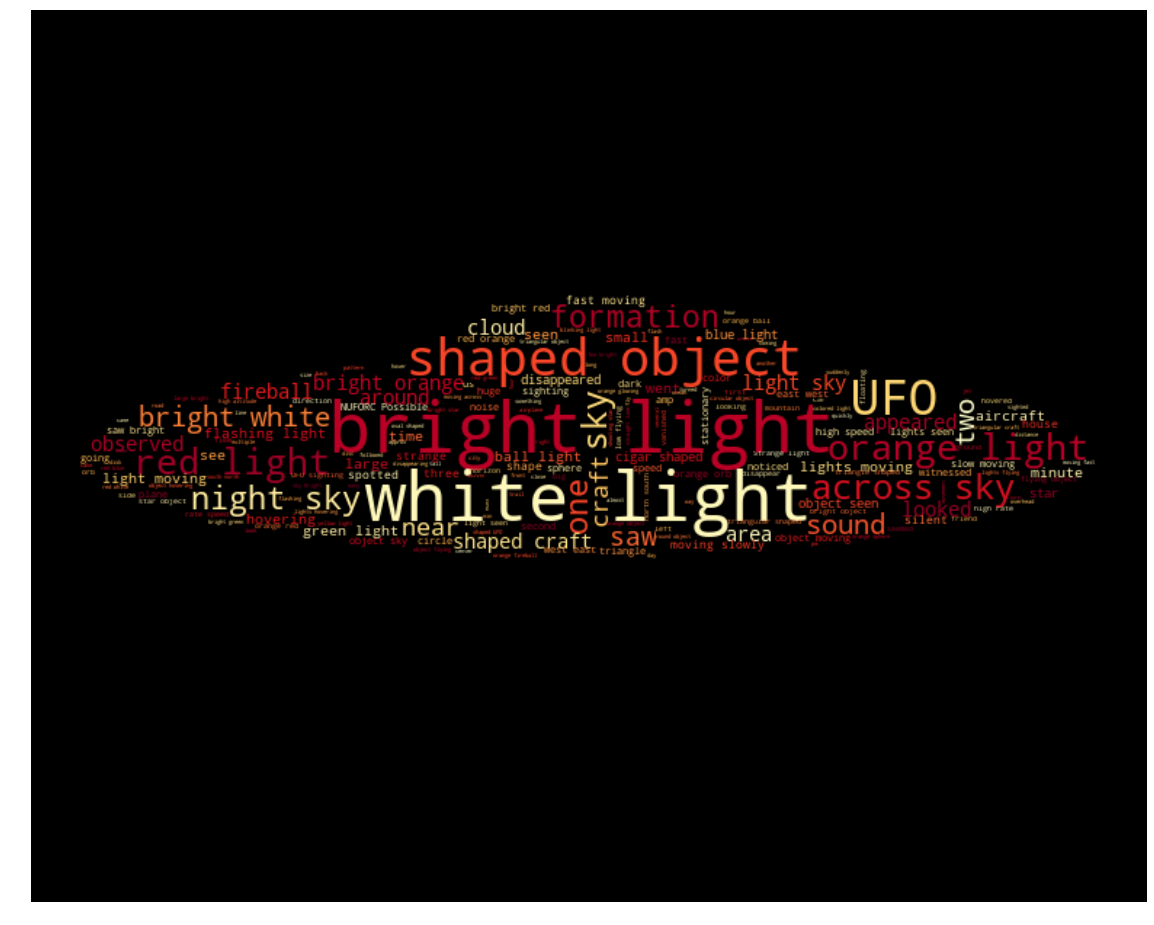

In [128]:
# Create the wordcloud object
wave_mask = np.array(Image.open( "ufo_craft.jpg"))

#wordcloud = WordCloud(width=480, height=480, margin=0, mask=wave_mask, background_color='skyblue', 
#colormap='Greens').generate(text)
wordcloud = WordCloud(width=480, height=480, margin=0, mask=wave_mask, colormap="YlOrRd").generate(text)

plt.figure(figsize=(20,20))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

## Time analysis

**conclustion draft : ** 
- UFO loves warm and summer as people do
- but unlike people and similar to vampires, it likes to stay in the shadow


In [76]:
ufo['month'] = ufo['datetime'].dt.month.astype(int)
ufo['day'] = ufo['datetime'].dt.day.astype(int)
ufo['day of the week'] = ufo['datetime'].dt.dayofweek.astype(int)
ufo['hour'] = ufo['datetime'].dt.hour.astype(int)
ufo['day of year'] = ufo['datetime'].dt.strftime('%m-%d')

In [131]:
temp = ufo['day of the week'].value_counts()
temp.sort_index(inplace=True)

<BarContainer object of 7 artists>

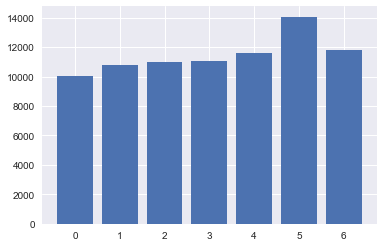

In [132]:
plt.bar(temp.index, temp)

In [133]:
temp = ufo['month'].value_counts()
temp.sort_index(inplace=True, ascending=False)

<BarContainer object of 12 artists>

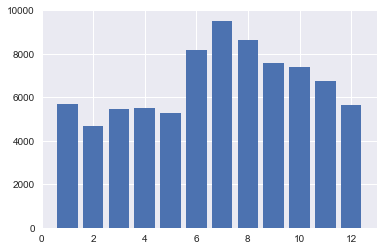

In [134]:
plt.bar(temp.index, temp)

In [136]:
temp = ufo['day'].value_counts()
temp.sort_index(inplace=True)


<BarContainer object of 31 artists>

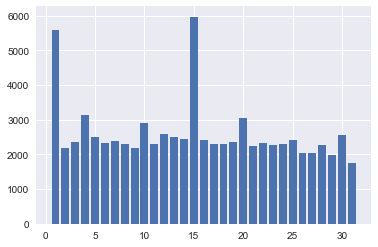

In [137]:
plt.bar(temp.index, temp)

In [138]:
ufo.columns

Index(['datetime', 'city', 'state', 'country', 'shape', 'comments',
       'date posted', 'latitude', 'longitude', 'duration_sec', 'duration_min',
       'longitude', 'year', 'month', 'day', 'day of the week', 'hour',
       'day of year'],
      dtype='object')

In [14]:
temp = ufo['hour'].value_counts()
temp.sort_index(inplace=True)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Anaconda\lib\site-packages\pandas\core\indexes\base.py", line 3063, in get_loc
    return self._engine.get_loc(key)
  File "pandas\_libs\index.pyx", line 140, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 162, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1492, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1500, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'hour'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-9185a65a8d44>", line 1, in <module>
    temp = ufo['hour'].value_counts()
  File "C:\Anaconda\lib\site-packages\pandas\core\frame.py", line 26

TypeError: must be str, not list

<BarContainer object of 24 artists>

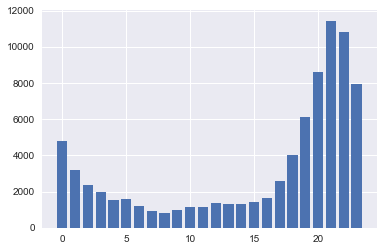

In [140]:
plt.bar(temp.index, temp)

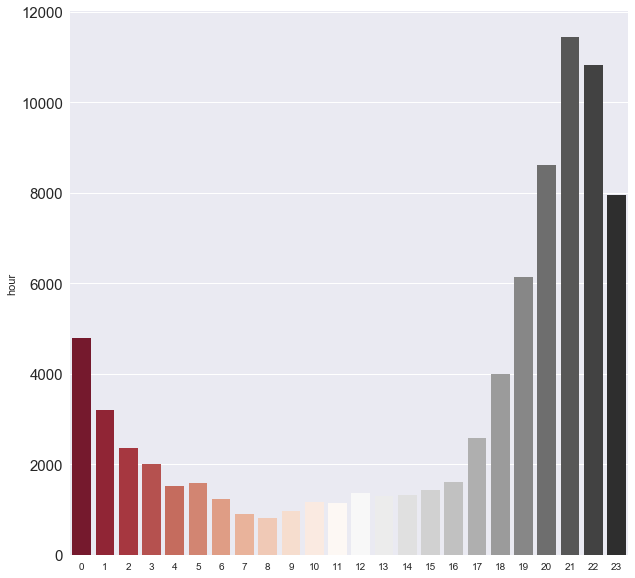

In [151]:
# TOFIX : background color to see the medium spectra
plt.figure(figsize=(10,10))
sns.barplot(temp.index, temp, palette="RdGy")
plt.yticks(fontsize=15)
plt.show()

In [24]:
temp = ufo[['country', 'duration_min']]

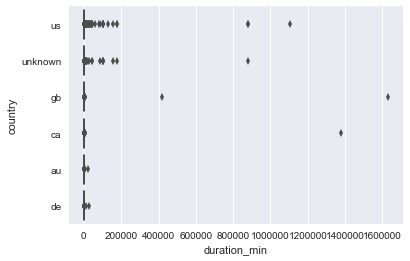

In [25]:
sns.boxplot(x=temp['duration_min'], y=temp['country'])

In [27]:
temp = temp[temp['duration_min'] < q]

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text yticklabel objects>)

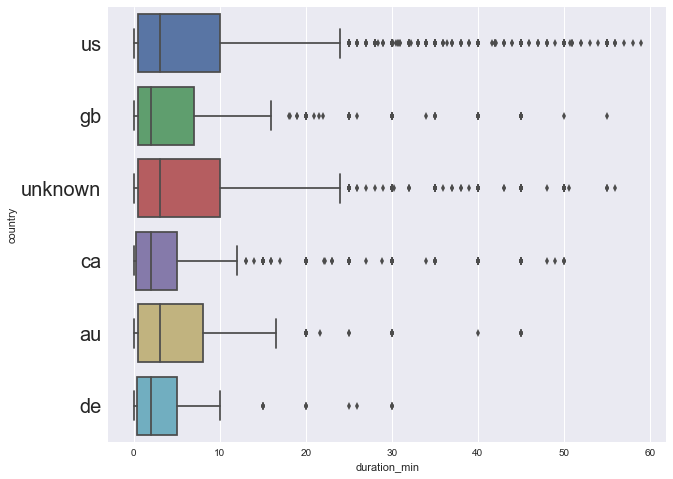

In [30]:
plt.figure(figsize=(10,8))
sns.boxplot(x=temp['duration_min'], y=temp['country'])
plt.yticks(fontsize=20)

In [55]:
temp = ufo[['state', 'duration_min']]

In [56]:
temp = temp[temp['duration_min'] < q]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]), <a list of 40 Text yticklabel objects>)

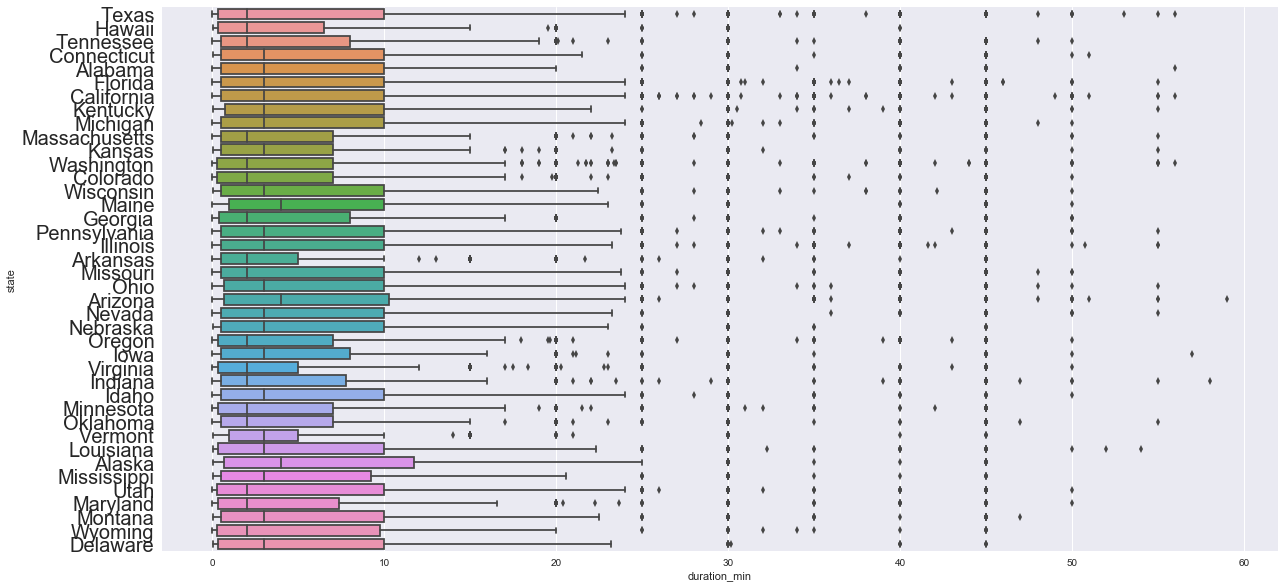

In [57]:
plt.figure(figsize=(20, 10))
sns.boxplot(x=temp['duration_min'], y=temp['state'])
plt.yticks(fontsize=20)

In [17]:
temp = ufo[['shape', 'duration_min']]

In [20]:
temp = temp[temp['duration_min'] < q]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 <a list of 28 Text yticklabel objects>)

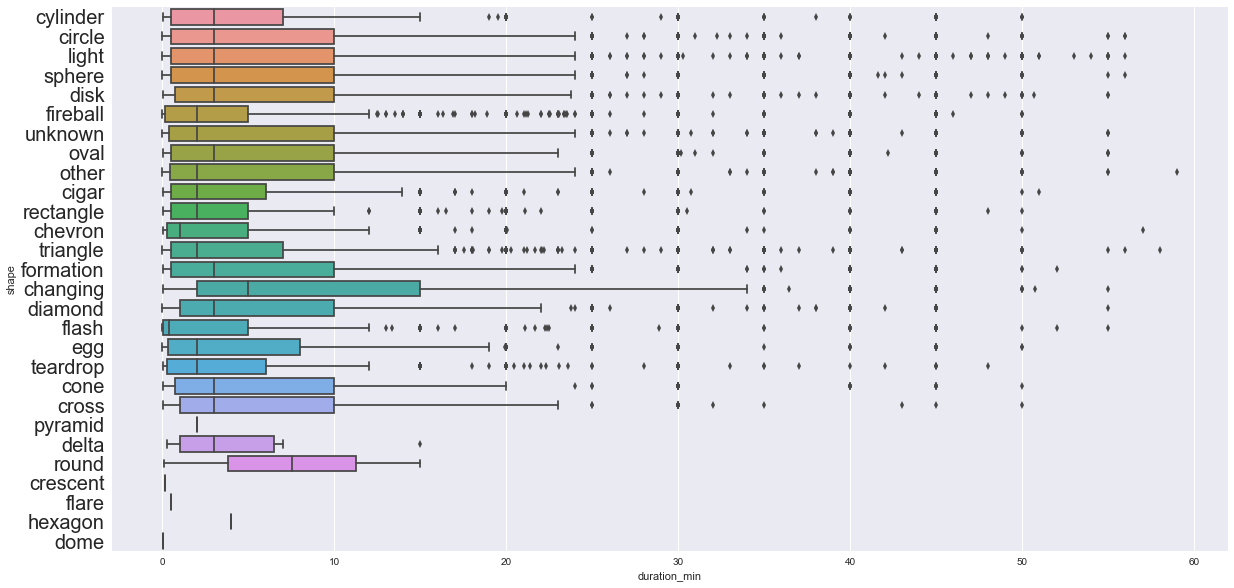

In [61]:
plt.figure(figsize=(20, 10))
sns.boxplot(x=temp['duration_min'], y=temp['shape'])
plt.yticks(fontsize=20)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 <a list of 28 Text xticklabel objects>)

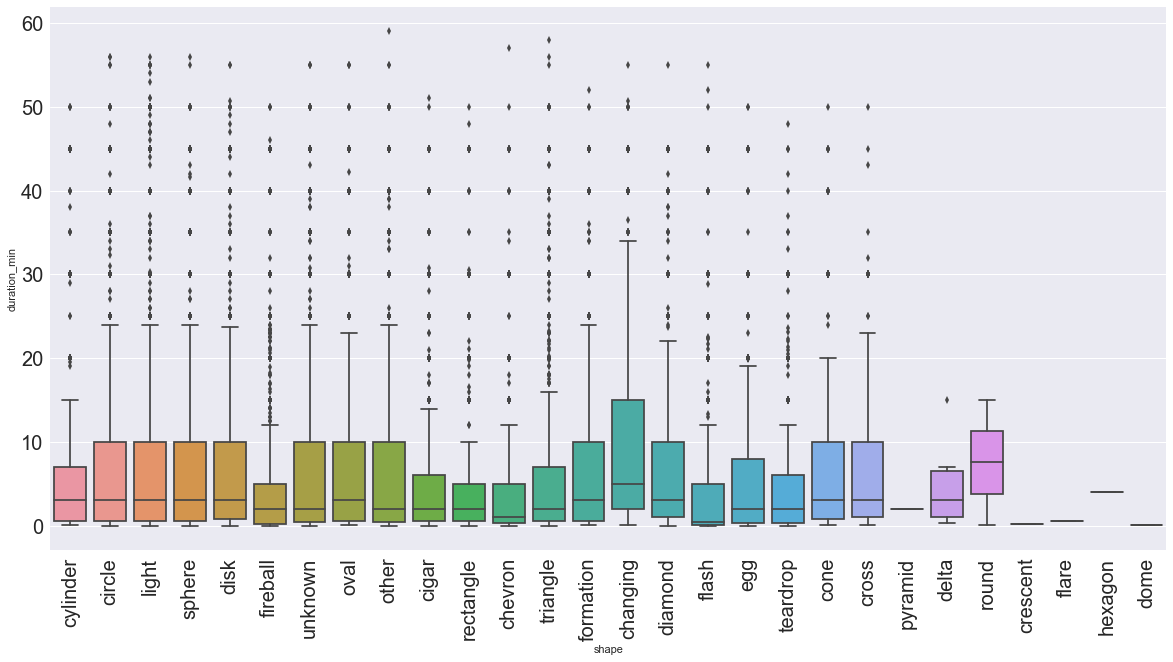

In [27]:

plt.figure(figsize=(20, 10))
sns.boxplot(x=temp['shape'], y=temp['duration_min'], orient='v' )
plt.yticks(fontsize=20)
plt.xticks(rotation='vertical', fontsize=20)

## trying to get country by coords

- it seems it's better to use google maps api. as geocoder is so slow........

In [29]:
import reverse_geocoder as rg

In [82]:
container = []

countries = ufo['country']

for country in countries:
    if country == 'unknown':
        print(country)
        
        current_row = pd.Index(countries).get_loc(country)
        print(current_row)
        break

unknown
[False  True False ... False False False]


In [97]:
indices = countries.where(countries == 'unknown')

In [98]:
type(indices)

pandas.core.series.Series

In [107]:
ufo.columns

Index(['datetime', 'city', 'state', 'country', 'shape', 'comments',
       'date posted', 'latitude', 'longitude', 'duration_sec', 'duration_min',
       'longitude', 'year', 'month', 'day', 'day of the week', 'hour',
       'day of year'],
      dtype='object')

In [118]:
row = 0
for i in indices:
    
    if i == 'unknown':
        #print(i)
        lat = ufo.iloc[row, 7]
        long = ufo.iloc[row, 8]
        geo_data = rg.search((lat, long))
        
        # taking string, which is object on the map name
        #print(geo_data[0]['name'])
        
        # taking country
        #print(geo_data[0]['cc'].lower())
        #break
        
        new_country = geo_data[0]['cc'].lower()
        ufo.iloc[row, 3] = new_country
        
    row += 1
    
    

KeyboardInterrupt: 

In [104]:
ufo.head()

,datetime,city,state,country,shape,comments,date posted,latitude,longitude,duration_sec,duration_min,longitude,year,month,day,day of the week,hour,day of year
0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111,2700.0,45.000000,-97.941111,1949,10,10,0,20,10-10
1,1949-10-10 21:00:00,lackland afb,tx,unknown,light,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.384210,-98.581082,7200.0,120.000000,-98.581082,1949,10,10,0,21,10-10
2,1955-10-10 17:00:00,chester (uk/england),unknown,gb,circle,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.200000,-2.916667,20.0,0.333333,-2.916667,1955,10,10,0,17,10-10
3,1956-10-10 21:00:00,edna,tx,us,circle,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833,20.0,0.333333,-96.645833,1956,10,10,2,21,10-10
4,1960-10-10 20:00:00,kaneohe,hi,us,light,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611,900.0,15.000000,-157.803611,1960,10,10,0,20,10-10
